## surface temperature (tas)

In [1]:
import intake
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import os

import myFuncs
import myPlots


#import dask
#dask.config.set(**{'array.slicing.split_large_chunks': True})


In [2]:
models = [
        # 'IPSL-CM5A-MR', # 1
         'GFDL-CM3',     # 2
        # 'GISS-E2-H',    # 3
        # 'bcc-csm1-1',   # 4
        # 'CNRM-CM5',     # 5
        # 'CCSM4',        # 6 # cannot concatanate files for historical run
        # 'HadGEM2-AO',   # 7
        # 'BNU-ESM',      # 8
        # 'EC-EARTH',     # 9
        # 'FGOALS-g2',    # 10
        # 'MPI-ESM-MR',   # 11
        # 'CMCC-CM',      # 12
        # 'inmcm4',       # 13
        # 'NorESM1-M',    # 14
        # 'CanESM2',      # 15 # slicing with .sel does not work, 'contains no datetime objects'
        # 'MIROC5',       # 16
        # 'HadGEM2-CC',   # 17
        # 'MRI-CGCM3',    # 18
        # 'CESM1-BGC'     # 19
        ]


model = models[0]


historical = False
rcp85 = True

if historical:
    experiment = 'historical'
    period=slice('1970-01','1999-12')
    ensemble = 'r1i1p1'

    if model == 'GISS-E2-H':
        ensemble = 'r6i1p1'

    if model == 'EC-EARTH':
        ensemble = 'r6i1p1'


if rcp85:
    experiment = 'rcp85'
    period=slice('2070-01','2099-12')
    ensemble = 'r1i1p1'

    if model == 'GISS-E2-H':
        ensemble = 'r2i1p1'

    if model == 'EC-EARTH':
        ensemble = 'r6i1p1'


ds_dict = intake.cat.nci['esgf'].cmip5.search(
                                        model_id = model, 
                                        experiment = experiment,
                                        time_frequency = 'mon', 
                                        realm = 'atmos', 
                                        ensemble = ensemble, 
                                        variable= 'tas').to_dataset_dict()


if not (model == 'FGOALS-g2' or model == 'CNRM-CM5'):
    ds_orig =ds_dict[list(ds_dict.keys())[-1]].sel(time=period, lon=slice(0,360),lat=slice(-35,35))

elif model == 'FGOALS-g2':
    ds_orig =ds_dict[list(ds_dict.keys())[-1]].isel(time=slice(12*120, 12*120 + 12*30)).sel(lon=slice(0,360), lat=slice(-35,35))
    
elif model == 'CNRM-CM5':
    ds_orig =ds_dict[list(ds_dict.keys())[-1]].isel(time=slice(12*64, 12*64 + 12*30)).sel(lon=slice(0,360), lat=slice(-35,35))


# print(ds_pr.pr.encoding), will show that missing values are represented as 1e+20, although importing it with intake converts them to nan


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.product.institute_id.model_id.experiment.time_frequency.realm.cmor_table.ensemble.version.variable'


In [3]:
haveDsOut = True
ds_tas = myFuncs.regrid_conserv(ds_orig, haveDsOut) # path='', model'')

In [4]:
ds_tas

<xarray.Dataset>
Dimensions:  (time: 360, lat: 22, lon: 128)
Coordinates:
  * time     (time) object 2070-01-16 12:00:00 ... 2099-12-16 12:00:00
    height   float64 2.0
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(12, 22, 128), meta=np.ndarray>
Attributes:
    regrid_method:  conservative

In [5]:
tas = ds_tas.tas-273.15
tas.attrs['units']= 'deg (C)'
tas

<xarray.DataArray 'tas' (time: 360, lat: 22, lon: 128)>
dask.array<sub, shape=(360, 22, 128), dtype=float32, chunksize=(60, 22, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2070-01-16 12:00:00 ... 2099-12-16 12:00:00
    height   float64 2.0
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:    deg (C)

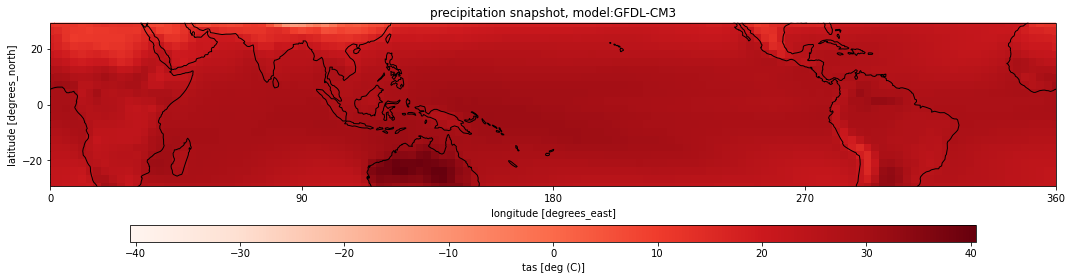

In [6]:
myPlots.plot_snapshot(tas.isel(time=0), 'Reds', 'precipitation', model)

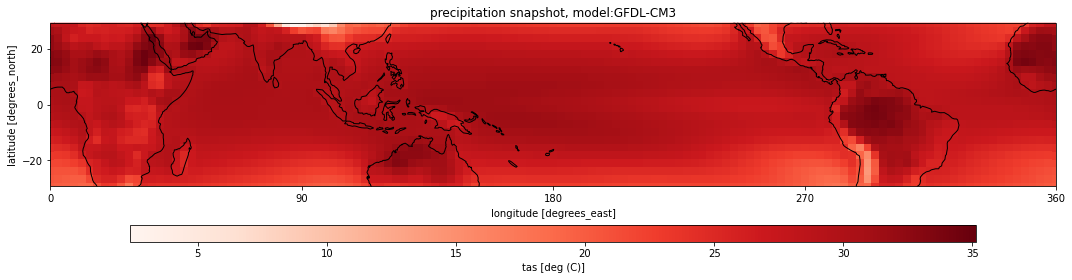

In [7]:
myPlots.plot_snapshot(tas.mean(dim='time', keep_attrs=True), 'Reds', 'precipitation', model) # 'coolwarm'

In [8]:
# as function
def get_tas_snapshot_tMean(tas):
    return tas.isel(time=0), tas.mean(dim='time', keep_attrs=True)


In [9]:
aWeights = np.cos(np.deg2rad(tas.lat))
tas_annual= tas.resample(time='Y').mean(dim='time', keep_attrs=True).weighted(aWeights).mean(dim=('lat','lon'))
tas_annual

<xarray.DataArray 'tas' (time: 30)>
dask.array<truediv, shape=(30,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * time     (time) object 2070-12-31 00:00:00 ... 2099-12-31 00:00:00

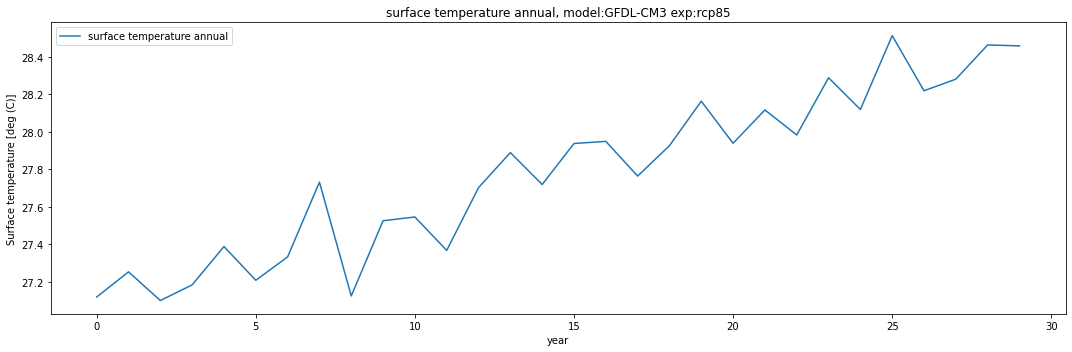

In [11]:
f, ax = plt.subplots(figsize=(15, 5))

da = xr.DataArray(tas_annual.data)
da.plot(ax=ax, label='surface temperature annual')
ax.set_title('surface temperature annual, model:' + model + ' exp:' + experiment)
ax.set_ylabel('Surface temperature [deg (C)]')
ax.set_xlabel('year')
ax.legend(loc = 'upper left')

plt.tight_layout()

## saving

In [12]:
folder = '/g/data/k10/cb4968/cmip5/' + model

In [13]:
# spatial mean temperature
save = False
if save:
    os.makedirs(folder, exist_ok=True)
    
    fileName = model + '_tas_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)    

    xr.Dataset({'tas_day': tas.isel(time=0), 'tas_tMean': tas.mean(dim='time', keep_attrs=True)}).to_netcdf(path)

In [14]:
# annual mean
save = False
if save:
    os.makedirs(folder, exist_ok=True)
    
    fileName = model + '_tas_annual_' + experiment + '.nc'
    path = folder + '/' + fileName
    if os.path.exists(path):
        os.remove(path)    

    xr.Dataset({'tas_annual': tas_annual}).to_netcdf(path)